# An Image Is Worth a Thousand Words
## Build Your First Intelligent Document Recognizer


#### Named Entity Recognition(NER) using Conditional Random Fields(CRF)

NER is the method of extracting relevant information from a corpus of data and classifying those entities into predefined categories such as merchant, date, amount etc. Conditional Random fields are a type of discriminative machine learning classifiers that model the decision boundary and classify the OCR data into different output classes.

# Dataset
We will be using a publicly available dataset consisting of receipts. Open a file in the below folders to look at the structure of the OCR outputs and annotations for the dataset we're using for this exercise.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

allOCRSet = "datasets/CleanOCR-all" # A folder with all OCR files
allAnnotationSet = "datasets/Annotations-all" # A folder with all Annotation files

# Introduction to Optical Character Recognition (OCR)
Use Pytesseract to apply OCR on a sample receipt image.

In [ ]:
# Run this to see the receipt image 

from IPython.display import Image
Image(filename='datasets/SplitYB.png') 

In [ ]:
import pytesseract
from PIL import Image

# Receipt image from a restaurant
image_path = "datasets/SplitYB.png"

# Send receipt image through tesseract OCR
def getOCRText(image_path):
    image_data = Image.open(image_path)
    image_text = pytesseract.image_to_string(image_data)
    return image_text

print(getOCRText(image_path))

# Text Labeling - Tokenize, Annotate and Tag

In order to get the text labeled and ready for the CRF model, we have to follow the following three steps:

1. <p>Tokenize</p>
Break the text into linguistic units. Ex: Tokenize on whitepspaces
2. <p>Annotate</p>
Label the truth data for the fields to be extracted. ex: date, amount and merchant
3. <p>Tag</p> 
    The IOB (short for inside, outside, beginning) is a common tagging format for tagging tokens.
    I- prefix before a tag indicates that the tag is inside a chunk.
    B- prefix before a tag indicates that the tag is the beginning of a chunk.
    An O tag indicates that a token belongs to no chunk (outside).

In [ ]:
import pandas as pd
import os
import json

In [ ]:
allNerDataset = "datasets/ner-dataset.csv"

def dataAnnotation(OCRset, annotationSet, nerDataset):
	allCleanOCRFiles = os.listdir(OCRset) # Load all Clean OCR Files
	allIXFiles = os.listdir(annotationSet) # Load all Clean OCR Files
	outfile = open(nerDataset, 'w')
	receiptNum = 0
	outfile.write('Receipt #,Word,POS,Tag' + '\n')

	for ixfile in allIXFiles:
		filename = os.fsdecode(ixfile)
		for ocrfile in allCleanOCRFiles:
			ocrFilename = os.fsdecode(ocrfile)
			if filename == ocrFilename and not filename.startswith('.'):
				ixData = {}
				ocrCleanLine = ""
				with open(annotationSet + '/' + filename) as f1:
					ixData = json.load(f1)
				with open(OCRset + '/' + filename) as f2:
					ocrCleanLine = f2.readlines()
				annotationLine = ""
				wordNum = 0
				words = ocrCleanLine[0].replace(',', '').split(' ')
				isAmount = False
				isDate = False
				isMerchant = False
				beginMerchant = False
				beginDate = False

				merchantParts = ixData['company'].split(' ')
				dateParts = ixData['date'].split(' ')
				
				for word in words:
					annotationLine = ""
					word = word.replace(',', ' ')
					if wordNum == 0:
						if word == dateParts[0] and not isDate:
							annotationLine = 'Receipt: ' + str(receiptNum) + ',' + word + ',' + "DT" + ',' + 'B-date'
							isDate = True
							# Only expect a I-date if there are multiple parts to the date
							if len(dateParts) > 1:
								beginDate = True
							else:
								beginDate = False
						elif word == ixData['total'] and not isAmount:
							annotationLine = 'Receipt: ' + str(receiptNum) + ',' + word + ',' + "AM" + ',' + 'B-amt'
							isAmount = True
						elif word == merchantParts[0] and not isMerchant:
							annotationLine = 'Receipt: ' + str(receiptNum) + ',' + word + ',' + "MR" + ',' + 'B-mer'
							isMerchant = True
							beginMerchant = True
						else:
							annotationLine = 'Receipt: ' + str(receiptNum) + ',' + word + ',' + "NN" + ',' + 'O'
					else:
						#Date tagging
						if word == dateParts[0] and not isDate:
							annotationLine = ',' + word + ',' + "DT" + ',' + 'B-date'
							isDate = True
							# Only expect a I-date if there are multiple parts to the date
							if len(dateParts) > 1:
								# print("This date has many parts: " + ixData['date'])
								beginDate = True
							else:
								beginDate = False
						elif word in ixData['date'] and word != dateParts[0] and word != dateParts[-1] and beginDate:
							annotationLine = ',' + word + ',' + "DT" + ',' + 'I-date'
						elif word == dateParts[-1] and beginDate:
							beginDate = False
							annotationLine = ',' + word + ',' + "DT" + ',' + 'I-date'
						# Amount tagging
						elif word == ixData['total'] and not isAmount:
							annotationLine = ',' + word + ',' + "AM" + ',' + 'B-amt'
							isAmount = True

						# Merchant tagging
						elif word == merchantParts[0] and not isMerchant:
							beginMerchant = True
							isMerchant = True
							annotationLine = ',' + word + ',' + "MR" + ',' + 'B-mer'
						elif word in ixData['company'] and word != merchantParts[0] and word != merchantParts[-1] and beginMerchant:
							annotationLine = ',' + word + ',' + "MR" + ',' + 'I-mer'
						elif word == merchantParts[-1] and beginMerchant:
							beginMerchant = False
							annotationLine = ',' + word + ',' + "MR" + ',' + 'I-mer'

						#Other tagging
						else:
							annotationLine = ',' + word + ',' + "NN" + ',' + 'O'
					wordNum += 1						
					outfile.write(annotationLine + '\n')
				receiptNum += 1
	outfile.close
	print ('Annotations for %d files completed!' %receiptNum)
dataAnnotation(allOCRSet, allAnnotationSet, allNerDataset)

# NER Model Training

CRF is used for predicting sequences using contextual information. The CRF model is a supervised model that requires labelled data. The data required for our model training consists of tokens from a particular receipt with their corresponding Part of Speech (POS) tag and their BIO scheme tag. 

Below is the formula for CRF where y is the output variable and X is input sequence:
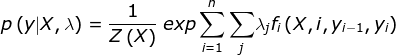

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.datasets import make_blobs

In [ ]:
#Reading the csv file
df = pd.read_csv('datasets/ner-dataset-1000.csv', encoding = "ISO-8859-1")

#Display first 10 rows
df.head(10)
df.describe()
#Displaying the unique Tags
df['Tag'].unique()
#Checking null values, if any.
df.isnull().sum()
df = df.fillna(method = 'ffill')

In [ ]:
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Receipt #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Receipt: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None
        
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

#sentence with its pos and tag.
sent = getter.get_text()
# print(sent)
sentences = getter.sentences

## Feature Functions

We will be using the default features used by the NER in Natural Language Toolkit (NLTK) as a starting point. This includes word identity, word suffix, word shape and word POS tag in addition to some information from nearby words. We can modify and add to these features in order to improve accuracy as needed.

In [ ]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += ele   
    
    # return string   
    return str1

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

## Train

The data is then fed into the CRF model trainer provided by Scikit-learn.

In [ ]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6)

crf = CRF(algorithm = 'lbfgs',
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)
crf.fit(X_train, y_train)

## Test 

In [ ]:
#Predicting on the test set.
y_pred = crf.predict(X_test)

def printPredictions(y_pred):
	for i in range(len(y_pred)):
		prediction = y_pred[i]
		testList = X_test[i]
		testSentence = ""
		for testTuple in testList:
			testSentence = testSentence + testTuple['word.lower()'] + ' '
		words = testSentence.split(" ")
		x = 0
		for wordPrediction in prediction:
			if wordPrediction == 'B-date' or wordPrediction == 'B-amt' or wordPrediction == 'B-mer' or wordPrediction == 'I-mer' or wordPrediction == 'I-date':
				print('%s : %s' % (wordPrediction, words[x]))
			x +=1

printPredictions(y_pred)

## Generate Report and Analyze Results
Print the results of how your model was trained and tested to verify

In [ ]:
f1_score = flat_f1_score(y_test, y_pred, average = 'weighted')
print("Flat F1 Score: %f \n" %f1_score)

report = flat_classification_report(y_test, y_pred)
print(report)

# Practical Application

Now, lets test a new receipt that the machine learning model hasn't encountered before.

- Option 1: Upload a receipt image to the dataset directory.
- Option 2: Use the lunch.png image available.

## Test End to End by uploading a new image - OCR to NER

In [ ]:
# Run this to see the receipt image 

from IPython.display import Image
Image(filename='datasets/lunch.png') 

In [ ]:
from PIL import Image

new_image_path = "datasets/lunch.png"
test_file = getOCRText(new_image_path)

test_ocr_sentence = test_file.replace("\n", " ")
print(test_ocr_sentence)


## Annotate the test image

1. Add the OCR output from above to the OCR file in CleanOCR-test directory
2. Add the corresponding annotations to a file in the Annotations-test directory

Ensure that the 2 files have identical names in order for the next step to work as expected.

In [ ]:
testOCRSet = "datasets/CleanOCR-test" # A folder with all OCR files
testAnnotationSet = "datasets/Annotations-test" # A folder with all Annotation files
testNerDataset = "datasets/ner-dataset-test.csv"

dataAnnotation(testOCRSet,testAnnotationSet, testNerDataset)

In [ ]:
def get_test_sentence(test_file):
    #Reading the csv file
    trial = pd.read_csv(test_file, encoding = "ISO-8859-1")

    #Display first 10 rows
    trial.head(10)
    trial.describe()
    #Displaying the unique Tags
    trial['Tag'].unique()
    #Checking null values, if any.
    trial.isnull().sum()
    trial = trial.fillna(method = 'ffill')
    trial_getter = sentence(trial) # Check last token - seems to be repeating 
    trial_sentences = [" ".join([s[0] for s in sent]) for sent in trial_getter.sentences]
    trial_sentences[0]

    #sentence with its pos and tag.
    trial_sent = trial_getter.get_text()
    trial_sentences = trial_getter.sentences
    return trial_sentences

trial_sentences = get_test_sentence(testNerDataset)

In [ ]:
tX = [sent2features(s) for s in trial_sentences]
ty = [sent2labels(s) for s in trial_sentences]

#Predicting on the one test set.
X_test = tX
y_test = ty
y_pred = crf.predict(X_test)

f1_score = flat_f1_score(y_test, y_pred, average = 'weighted')
print("Flat F1 Score: %f \n" %f1_score)

report = flat_classification_report(y_test, y_pred)
print(report)

printPredictions(y_pred)